# RAG ( Retrieval Augmented Generation )

--------------------------------------------------------------------------------------------------------

### 1. What is RAG ?
   
* Retrieval-Augmented Generation (RAG) is a method that combines information retrieval and text generation.

* If the user asks any query , the RAG  first searches for relevant information from a large collection of documents. Then, it uses that information to create a more accurate and helpful response to a user's question.

--------------------------------------------------------------------------------------------------------

### 2. 2 Main Components of RAG

##### Indexing
* A pipeline for ingesting data from a source and indexing it. This usually happens offline.

##### Retrieval and generation:
* RAG chain takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

--------------------------------------------------------------------------------------------------------

### 2.1 . Data Preparation

##### Load / Data Ingestion:
* First we need to load our data using Document Loaders.

##### Split : 
* Then we will split this entire data into smaller chunks, since the LLM models has a token limit/ context window.

##### Embed
* Then we will convert the text into vectors.

##### Store
* The vectors are then stored in Vectorstore Database.

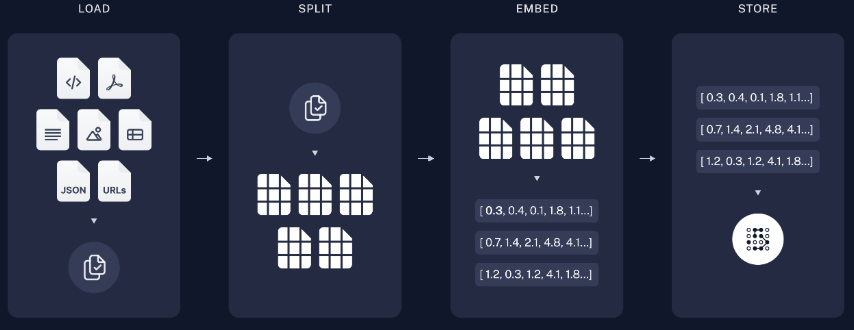

------------------------------------------------------------------------------------------------------

### 2.2 Retrieval and generation

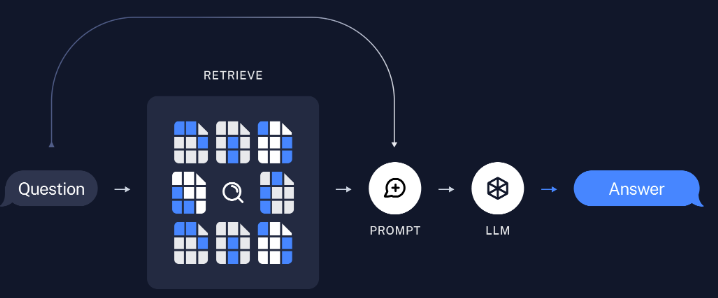

##### Retrieve:
* if user asks any query, relevant splits are retrieved from the vector db using a Retrieval chain.
* retrieval chain : It is an interface which is responsible for querying vector store db

##### Generate:
* we also design a seperate prompt (act like a AI researcher). we combine the user query with particular prompt and send to LLM.
* A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data

------------------------------------------------------------------------------------------------------

### Chain VS StuffDocumentChain
Chain:

* Takes a prompt + user query → LLM → output.
* Works fine when no retrieval is needed.
* But in RAG, we don’t just want the LLM to hallucinate—we need to inject retrieved documents.

Stuff Document Chain:

* It is especially created for RAG workflows.
* It stuffs the retrieved document into a single prompt, along with the user question.
* Passes this stuffed prompt into the LLM to generate an answer.

------------------------------------------------------------------------------------------------------

## Implementation

Note : RAG Happens in create_retrieval_chain

### 1. RAG WithOut Memory

* Without Memory it does not have any previous information.

In [ ]:
# Step 1 : Prepare the data

# Read the pdf and convert into document
loader = PyPDFDirectoryLoader("data") 
docs = loader.load()

# split the doc
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 50)
final_doc = text_splitter.split_documents(docs)

# Take only first 50 chunks, the pdf may be large.
final_doc = final_doc[:50]

# Initialize the embedding model and model
embeddings = OpenAIEmbeddings()
llm = ChatGroq(model_name = "Llama3-8b-8192")

# Store the vectors in FAISS DB
db = FAISS.from_documents(final_doc, embeddings)

# Convert the db to Retriever
retriever = db.as_retriever()

#---------------------------------------------------------------------------------------------------

# Step 2 : Retrive and Generate: Retrieve the data based on user input and Generate the answer

# Create prompt
prompt = ChatPromptTemplate.from_template(
    """
    Answer the question based on the provided context only.
    Please provide the most accurate response based on the question.
    <context>
    {context}
    </context>
    Question:{input}
    """
)

# user query
user_query = "what is langchain?"

if user_query:
    # It stuffs the retrieved document into a single prompt, along with the user question.Passes this stuffed prompt into the LLM to generate an answer.
    document_chain = create_stuff_documents_chain(llm,prompt)

    # This is where RAG Happens, when the retrieval chain is invoked , the retriever internally takes the input and fetches the relevant information and uses the document again to generate answer.
    retrieval_chain = create_retrieval_chain(retriever, document_chain)

    # Invoke the retrieval chain with user input 
    response = retrieval_chain.invoke({'input':user_query})

    print(response)

------------------------------------------------------------------------------------------------------

### 2. RAG WithOut Memory but with sessionstate.

* In Streamlit, every time the user submits a query or clicks a button, the script reruns from Top to bottom.
* If you don’t use session_state, your chat history, or vector DB connections reset every time. ( Again take so much time for spliting, embedding etc..)

In [ ]:
# Create a function to Load the data, do Embedding and store in Vectordb ( With Session State , so that you need not do embeddings again)

def create_vector_embedding():
    if "vectors" not in st.session_state:
        #load the data
        st.session_state.loader = PyPDFDirectoryLoader("data")
        st.session_state.docs = st.session_state.loader.load()
        
        # split the doc
        st.session_state.text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 50)
        st.session_state.final_doc = st.session_state.text_splitter.split_documents(st.session_state.docs)
        
        # Take only first 50 chunks, the pdf may be large.
        st.session_state.final_doc = st.session_state.final_doc[:50]

        # Initialize the embedding model
        st.session_state.embeddings = OpenAIEmbeddings()

        # Store the vectors in FAISS DB
        st.session_state.db = FAISS.from_documents(st.session_state.final_doc, st.session_state.embeddings)

        # Convert the db to Retriever
        st.session_state.retriever = st.session_state.db.as_retriever()

#---------------------------------------------------------------------------------------------------

# Create a button
if st.button(" Read my Document !"):
    create_vector_embedding()
    st.write("Sucessfully Read Your document !")

# Create a text_input to get input from user
user_query = st.text_input(" Ask your Question")

#-----------------------------------------------------------------------------------------------------

# model
llm = ChatGroq(model_name = "Llama3-8b-8192")

# Create prompt
prompt = ChatPromptTemplate.from_template(
    """
    Answer the question based on the provided context only.
    Please provide the most accurate response based on the question.
    <context>
    {context}
    </context>
    Question:{input}
    """
)

if user_query:
    document_chain = create_stuff_documents_chain(llm,prompt)
    retrieval_chain = create_retrieval_chain(st.session_state.retriever, document_chain)
    response = retrieval_chain.invoke({'input':user_query})
    st.write(response['answer'])

------------------------------------------------------------------------------------------------------

### 3. RAG With Memory

In [ ]:
# Create session for for each user, so that each user conversation is stored to their ID.

# asks the user to enter the session ID, else it sets default session ID as "default_session"
session_id = st.text_input("Session ID", value="default_session")

# if "store" is not in session state , then create it to store chat history for that session id
if "store" not in st.session_state:
    st.session_state.store = {}

#-----------------------------------------------------------------------------------------------------

# Function to get the Chat history based on the session id

def get_session_history(session: str) -> BaseChatMessageHistory:
    if session_id not in st.session_state.store:  # if session id not in store
        st.session_state.store[session_id] = ChatMessageHistory()  # store the new session_id along with History.
    return st.session_state.store[session_id]  # if the session_id already in store then return the chat history of that session id

#-----------------------------------------------------------------------------------------------------

# Create a function to Load the data, do Embedding and store in Vectordb ( With Session State , so that you need not do embeddings again)

def create_vector_embedding():
    if "vectors" not in st.session_state:
        #load the data
        st.session_state.loader = PyPDFDirectoryLoader("data")
        st.session_state.docs = st.session_state.loader.load()
        
        # split the doc
        st.session_state.text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 50)
        st.session_state.final_doc = st.session_state.text_splitter.split_documents(st.session_state.docs)
        
        # Take only first 50 chunks, the pdf may be large.
        st.session_state.final_doc = st.session_state.final_doc[:50]

        # Initialize the embedding model
        st.session_state.embeddings = OpenAIEmbeddings()

        # Store the vectors in FAISS DB
        st.session_state.db = FAISS.from_documents(st.session_state.final_doc, st.session_state.embeddings)

        # Convert the db to Retriever
        st.session_state.retriever = st.session_state.db.as_retriever()

#---------------------------------------------------------------------------------------------------

# Create a button
if st.button(" Read my Document !"):
    create_vector_embedding()
    st.write("Sucessfully Read Your document !")

# model
llm = ChatGroq(model_name = "Llama3-8b-8192")

#-----------------------------------------------------------------------------------------------------

# PROMPT 1: Instruct the llm how to retrieve text.
# instruct llm to reframe the question if necessary based on chat history. If the latest
# question is ambiguous or relies on previous context, the retrieval process may fail. so
# creating standalone question is necessary for retrieval process

contextualize_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. DO NOT answer the question, "
    "just reformulate it if needed and otherwise return it as it is."
)

contextualize_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_prompt),  # System message → Instructions for the AI
        ("user", "{input}"),  # User message → The latest question
        MessagesPlaceholder("chat_history")  # Chat history → Previous conversation context
    ]
)

# Create retriever with memory: The user question and chat history are fed into the
# contextualize_prompt_template, which the LLM reformulates into a standalone question.
# This reformulated question is then sent to the retriever to fetch relevant information.

history_aware_retriever = create_history_aware_retriever ( llm, retriever ,contextualize_prompt_template )

# -----------------------------------------------------------------------------------------

# PROMPT 2: Instruct the llm how to generate text.

qa_prompt = (
    "You are an assistant for Question-answering task."
    "use the following pieces of retrieved context to answer the question"
    "If you don't know the answer, say that you don't know"
    "Use three sentences maximum and keep the answer concise."
    "/n/n"
    "{context}"
)

qa_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", qa_prompt),  # System message → Instructions for the AI
        ("user", "{input}"),  # User message → The latest question
        MessagesPlaceholder("chat_history")  # Chat history → Previous conversation context
    ]
)

# -----------------------------------------------------------------------------------------

# Chains

# Create a stuff document chain to chain llm and prompt
document_chain = create_stuff_documents_chain(llm, qa_prompt_template)

# use history_aware_retriever to retrieve relevant document and pass it to document chain
retrieval_chain = create_retrieval_chain(history_aware_retriever, document_chain)

# Connect Retrieval chain with session chat history  

# RunnableWithMessageHistory integrates the retrieval chain with chat history handling
conversational_rag_chain = RunnableWithMessageHistory(
    retrieval_chain,  # handles retrieval of relevant data and generating response
    get_session_history,  # Fetches previous chat history to provide context
    input_message_key="input",  # The key that maps to the user's current input
    history_messages_key="chat_history",  # The key that holds the chat history context
    output_messages_key="answer"  # The key that stores the generated answer
)
# -----------------------------------------------------------------------------------------

user_input = st.text_input("Ask any question from the PDF !")

if user_input:
    session_history = get_session_history(session_id)  # get chat history
    response = conversational_rag_chain.invoke(
        {"input": user_input},
        config={"configurable": {"session_id": session_id}},)
    # It provides the session ID as part of the configuration, which is useful for the
    # chain to understand that the current interaction is part of a specific session or
    # chat history
    st.write(st.session_state.store)
    st.write("Assistant:", response['answer'])
    st.write("Chat History:", session_history.messages)
    

------------------------------------------------------------------------------------------------------